# BEL Statement Comparison Analysis
## Analysis of LLM vs INDRA BEL statement extraction results

In [1]:
import sys
import os

# Get the path to the parent directory (one level up)
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add it to sys.path if not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from luna_matplotlib_theme import apply_luna_theme

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load the data
print("Loading BEL comparison results...")
df = pd.read_csv('bel_comparison_results.csv')
print(f"Loaded {len(df)} comparison records")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\nDataset Overview:")
print(f"Total comparisons: {len(df)}")
print(f"Unique evidence texts: {df['evidence'].nunique()}")
print(f"Unique indices: {df['index'].nunique()}")

Loading BEL comparison results...
Loaded 74 comparison records
Columns: ['index', 'evidence', 'llm_statement', 'indra_statement', 'llm_subject', 'llm_relationship', 'llm_object', 'indra_subject', 'indra_relationship', 'indra_object', 'subject_match', 'relationship_match', 'object_match', 'subject_namespace_match', 'object_namespace_match', 'match_score', 'similarity_rating', 'match_type']

Dataset Overview:
Total comparisons: 74
Unique evidence texts: 38
Unique indices: 17


In [4]:
df.head()

,index,evidence,llm_statement,indra_statement,llm_subject,llm_relationship,llm_object,indra_subject,indra_relationship,indra_object,subject_match,relationship_match,object_match,subject_namespace_match,object_namespace_match,match_score,similarity_rating,match_type
0,1,"Recently, metformin, the most widely used firs...","a(CHEBI:metformin) hasComponent a(CHEBI:N,N-di...",NaN,a(CHEBI:metformin),hasComponent,"a(CHEBI:N,N-dimethyl-4-nitrosoaniline)",NaN,NaN,NaN,False,False,False,False,False,0.000000,NaN,LLM Only
1,3,"Phosphorylation at S326 is mediated by AKT1, m...","act(p(HGNC:AKT1), ma(GO:""kinase activity"")) di...",NaN,"act(p(HGNC:AKT1), ma(GO:""kinase activity""))",directlyIncreases,"p(HGNC:HSF1, pmod(Ph, Ser, 326))",NaN,NaN,NaN,False,False,False,False,False,0.000000,NaN,LLM Only
2,3,AKT2 also phosphorylated S326 of HSF1 but show...,"act(p(HGNC:AKT2), ma(GO:""kinase activity"")) di...",p(HGNC:392 ! AKT2) directlyIncreases p(HGNC:52...,"act(p(HGNC:AKT2), ma(GO:""kinase activity""))",directlyIncreases,"p(HGNC:HSF1, pmod(Ph, Ser, 326))",p(HGNC:AKT2),directlyIncreases,"p(HGNC:HSF1, pmod(go:0006468 ! ""protein phosph...",False,True,True,True,True,0.771023,Good,Best Match
3,3,"Similarly, mTOR, p38, MEK1 and DYRK2 all phosp...","act(p(HGNC:MTOR), ma(GO:""kinase activity"")) di...",NaN,"act(p(HGNC:MTOR), ma(GO:""kinase activity""))",directlyIncreases,"p(HGNC:HSF1, pmod(Ph, Ser, 326))",NaN,NaN,NaN,False,False,False,False,False,0.000000,NaN,LLM Only
4,3,"Similarly, mTOR, p38, MEK1 and DYRK2 all phosp...","act(p(HGNC:MAP2K1), ma(GO:""kinase activity"")) ...",NaN,"act(p(HGNC:MAP2K1), ma(GO:""kinase activity""))",directlyIncreases,"p(HGNC:HSF1, pmod(Ph, Ser, 326))",NaN,NaN,NaN,False,False,False,False,False,0.000000,NaN,LLM Only


In [5]:
criteria = [
    'subject_match',
    'object_match',
    'relationship_match',
    'subject_namespace_match',
    'object_namespace_match'
]

summary = df[criteria].sum().to_frame('count')
summary['percent'] = (summary['count'] / len(df) * 100).round(2).astype(str) + '%'
summary

,count,percent
subject_match,6,8.11%
object_match,8,10.81%
relationship_match,11,14.86%
subject_namespace_match,16,21.62%
object_namespace_match,15,20.27%


In [6]:
# rows where subject and object names match but relationship disagrees
disagree = df[(df['subject_match']) & (df['object_match']) & (~df['relationship_match'])]
disagree[["llm_statement", "indra_statement"]].head()

,llm_statement,indra_statement


In [8]:
# Define rated_paired: paired statements with a similarity rating
rated_paired = df[df['indra_statement'].notna() & df['similarity_rating'].notna()]

# Count rows where subject_match, object_match, and relationship_match are all True
all_match = rated_paired[
    rated_paired['subject_match'] &
    rated_paired['object_match'] &
    rated_paired['relationship_match']
]

num_all_match = len(all_match)
pct_all_match = (num_all_match / len(rated_paired)) * 100 if len(rated_paired) > 0 else 0

print(f"Rows where subject, object, and relationship all match: {num_all_match} ({pct_all_match:.1f}%)")

Rows where subject, object, and relationship all match: 1 (3.4%)


## Match Type Distribution

MATCH TYPE DISTRIBUTION
match_type
LLM Only      45
Best Match    17
INDRA Only    12
Name: count, dtype: int64


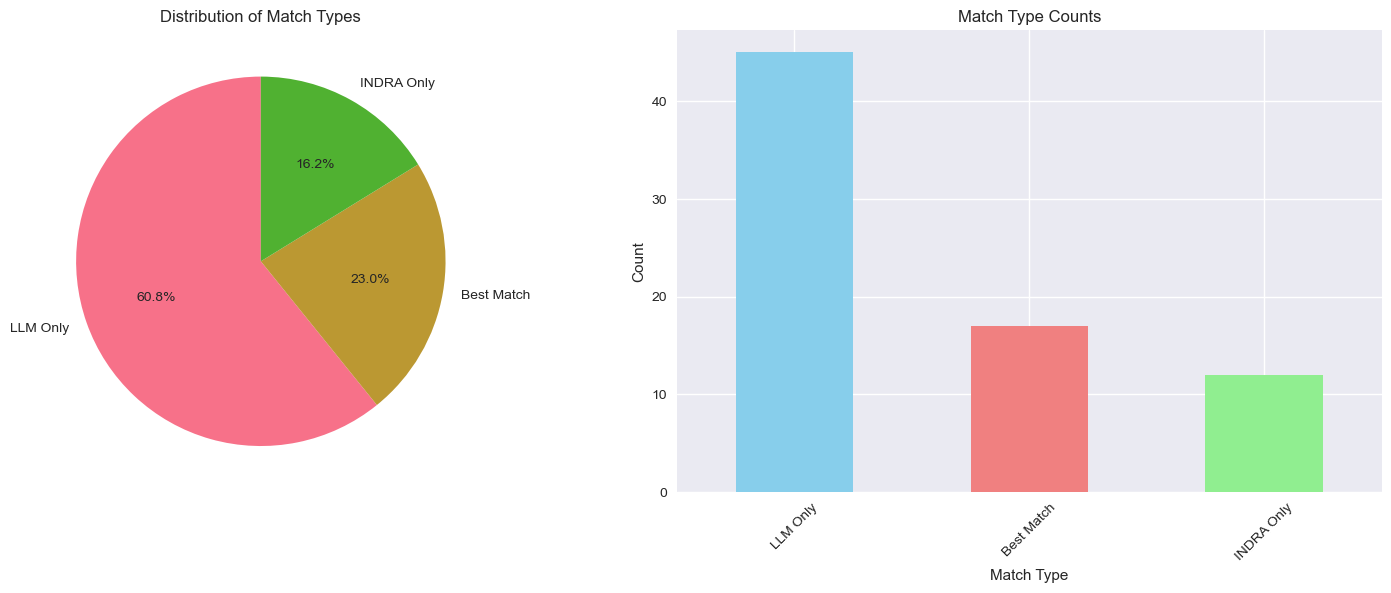

In [9]:
print("="*50)
print("MATCH TYPE DISTRIBUTION")
print("="*50)

match_counts = df['match_type'].value_counts()
print(match_counts)

# Create match type visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
ax1.pie(match_counts.values, labels=match_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribution of Match Types')

# Bar chart
match_counts.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Match Type Counts')
ax2.set_xlabel('Match Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

apply_luna_theme()
plt.tight_layout()
plt.show()

## Similarity Rating Analysis

SIMILARITY RATING ANALYSIS
Statements with similarity ratings: 29

Similarity Rating Distribution:
similarity_rating
Bad       18
Good       8
Medium     3
Name: count, dtype: int64


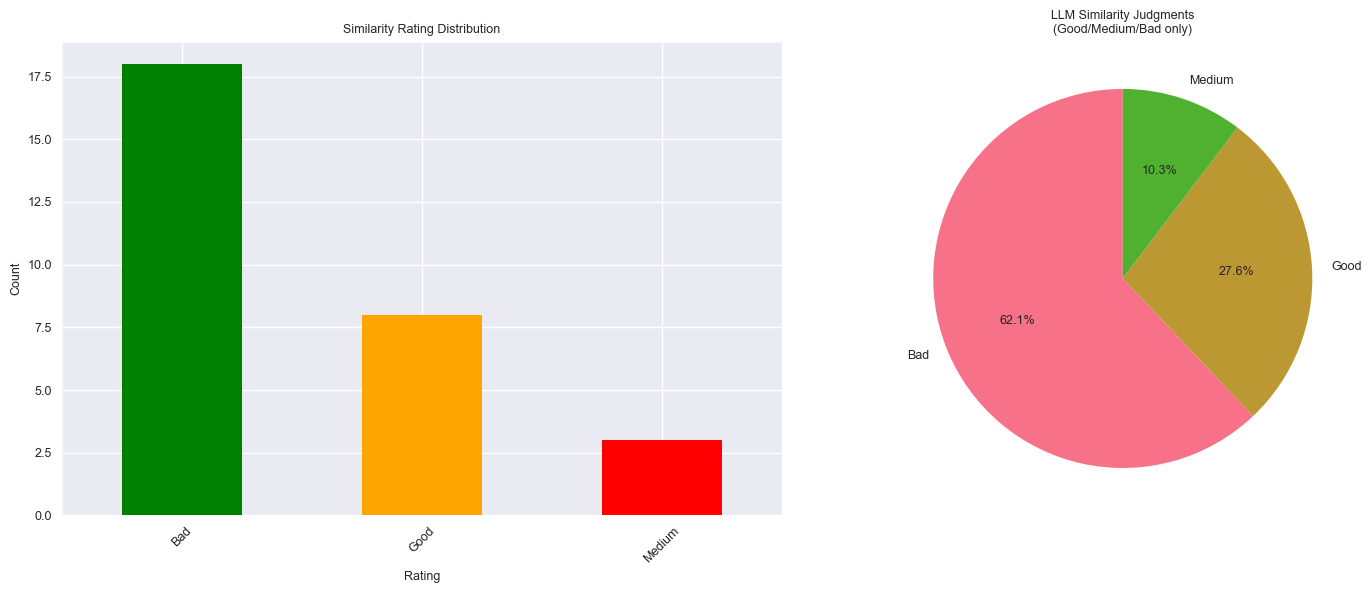

In [10]:
print("="*50)
print("SIMILARITY RATING ANALYSIS")
print("="*50)

# Filter only statements with ratings (exclude nulls)
rated_statements = df[df['similarity_rating'].notna()]
print(f"Statements with similarity ratings: {len(rated_statements)}")

if len(rated_statements) > 0:
    similarity_counts = rated_statements['similarity_rating'].value_counts()
    print("\nSimilarity Rating Distribution:")
    print(similarity_counts)
    
    # Similarity rating visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart
    similarity_counts.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red', 'gray'])
    ax1.set_title('Similarity Rating Distribution')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart for ratings (excluding non-rated)
    actual_ratings = similarity_counts[similarity_counts.index.isin(['Good', 'Medium', 'Bad'])]
    if len(actual_ratings) > 0:
        ax2.pie(actual_ratings.values, labels=actual_ratings.index, autopct='%1.1f%%', startangle=90)
        ax2.set_title('LLM Similarity Judgments\n(Good/Medium/Bad only)')
    
    apply_luna_theme()
    plt.tight_layout()
    plt.show()

## Component Matching Analysis

COMPONENT MATCHING ANALYSIS
Paired statements (LLM + INDRA): 29
Component Match Statistics:
Subject Match: 6/29 (20.7%)
Relationship Match: 11/29 (37.9%)
Object Match: 8/29 (27.6%)
Subject Namespace Match: 16/29 (55.2%)
Object Namespace Match: 15/29 (51.7%)


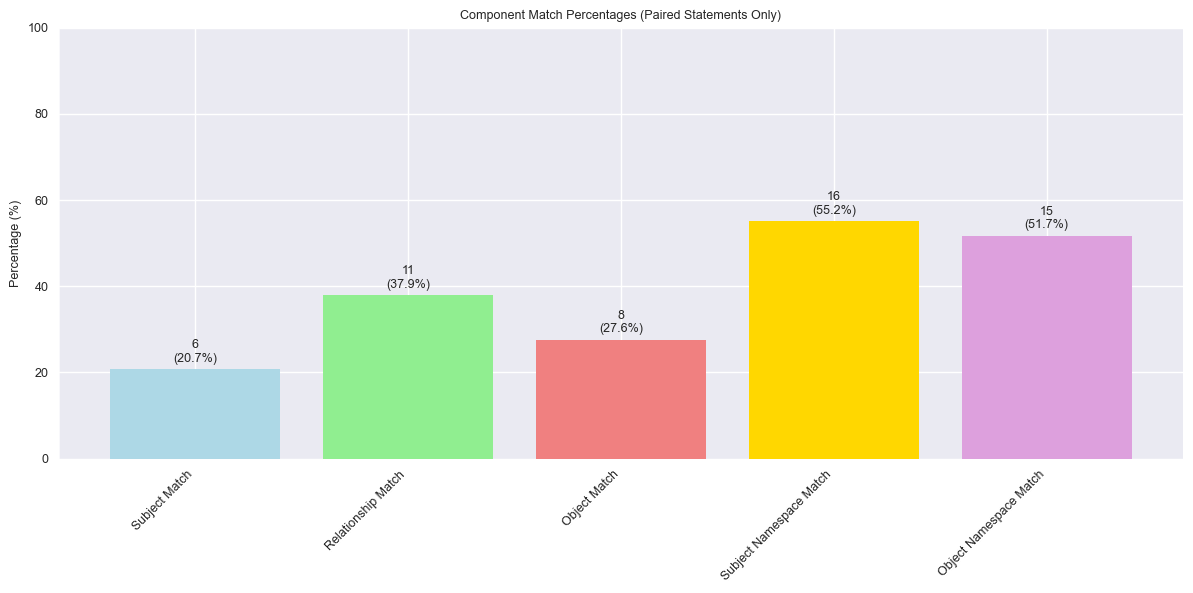

In [11]:
print("="*50)
print("COMPONENT MATCHING ANALYSIS")
print("="*50)

# Analyze component matches for paired statements only
paired_statements = df[df['indra_statement'].notna()]
print(f"Paired statements (LLM + INDRA): {len(paired_statements)}")

if len(paired_statements) > 0:
    # Component match statistics
    component_matches = {
        'Subject Match': paired_statements['subject_match'].sum(),
        'Relationship Match': paired_statements['relationship_match'].sum(),
        'Object Match': paired_statements['object_match'].sum(),
        'Subject Namespace Match': paired_statements['subject_namespace_match'].sum(),
        'Object Namespace Match': paired_statements['object_namespace_match'].sum()
    }
    
    print("Component Match Statistics:")
    for component, count in component_matches.items():
        percentage = (count / len(paired_statements)) * 100
        print(f"{component}: {count}/{len(paired_statements)} ({percentage:.1f}%)")
    
    # Visualize component matches
    fig, ax = plt.subplots(figsize=(12, 6))
    components = list(component_matches.keys())
    counts = list(component_matches.values())
    percentages = [(count/len(paired_statements))*100 for count in counts]
    
    bars = ax.bar(components, percentages, color=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
    ax.set_title('Component Match Percentages (Paired Statements Only)')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, count, pct in zip(bars, counts, percentages):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom')
    
    apply_luna_theme()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Relationship Type Analysis

RELATIONSHIP TYPE ANALYSIS
LLM Relationship Types:
llm_relationship
directlyIncreases    25
increases            10
decreases             5
directlyDecreases     2
hasComponent          1
Name: count, dtype: int64

INDRA Relationship Types:
indra_relationship
increases            17
directlyIncreases     8
directlyDecreases     2
partOf                2
Name: count, dtype: int64


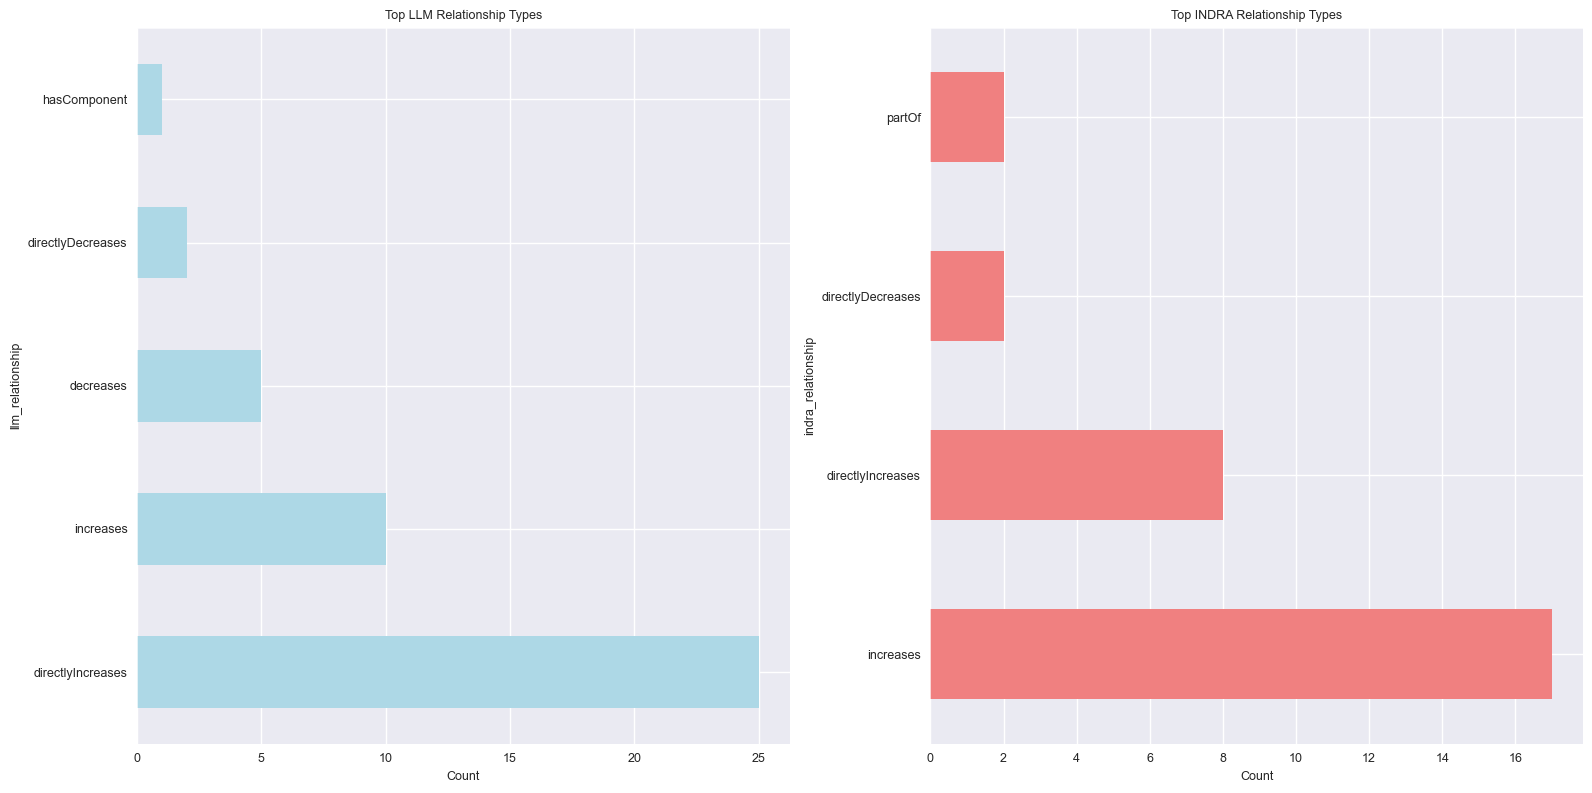

In [12]:
print("="*50)
print("RELATIONSHIP TYPE ANALYSIS")
print("="*50)

# Analyze relationship types
print("LLM Relationship Types:")
llm_relationships = df[df['llm_relationship'].notna()]['llm_relationship'].value_counts()
print(llm_relationships.head(10))

print("\nINDRA Relationship Types:")
indra_relationships = df[df['indra_relationship'].notna()]['indra_relationship'].value_counts()
print(indra_relationships.head(10))

# Visualize top relationships
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# LLM relationships
llm_relationships.head(8).plot(kind='barh', ax=ax1, color='lightblue')
ax1.set_title('Top LLM Relationship Types')
ax1.set_xlabel('Count')

# INDRA relationships
indra_relationships.head(8).plot(kind='barh', ax=ax2, color='lightcoral')
ax2.set_title('Top INDRA Relationship Types')
ax2.set_xlabel('Count')

apply_luna_theme()
plt.tight_layout()
plt.show()

## Namespace Analysis

NAMESPACE ANALYSIS
LLM Namespace Usage:
  HGNC: 103
  GO: 40
  CHEBI: 8
  FPLX: 4

INDRA Namespace Usage:
  HGNC: 45
  FPLX: 13
  GO: 1
  TEXT: 1


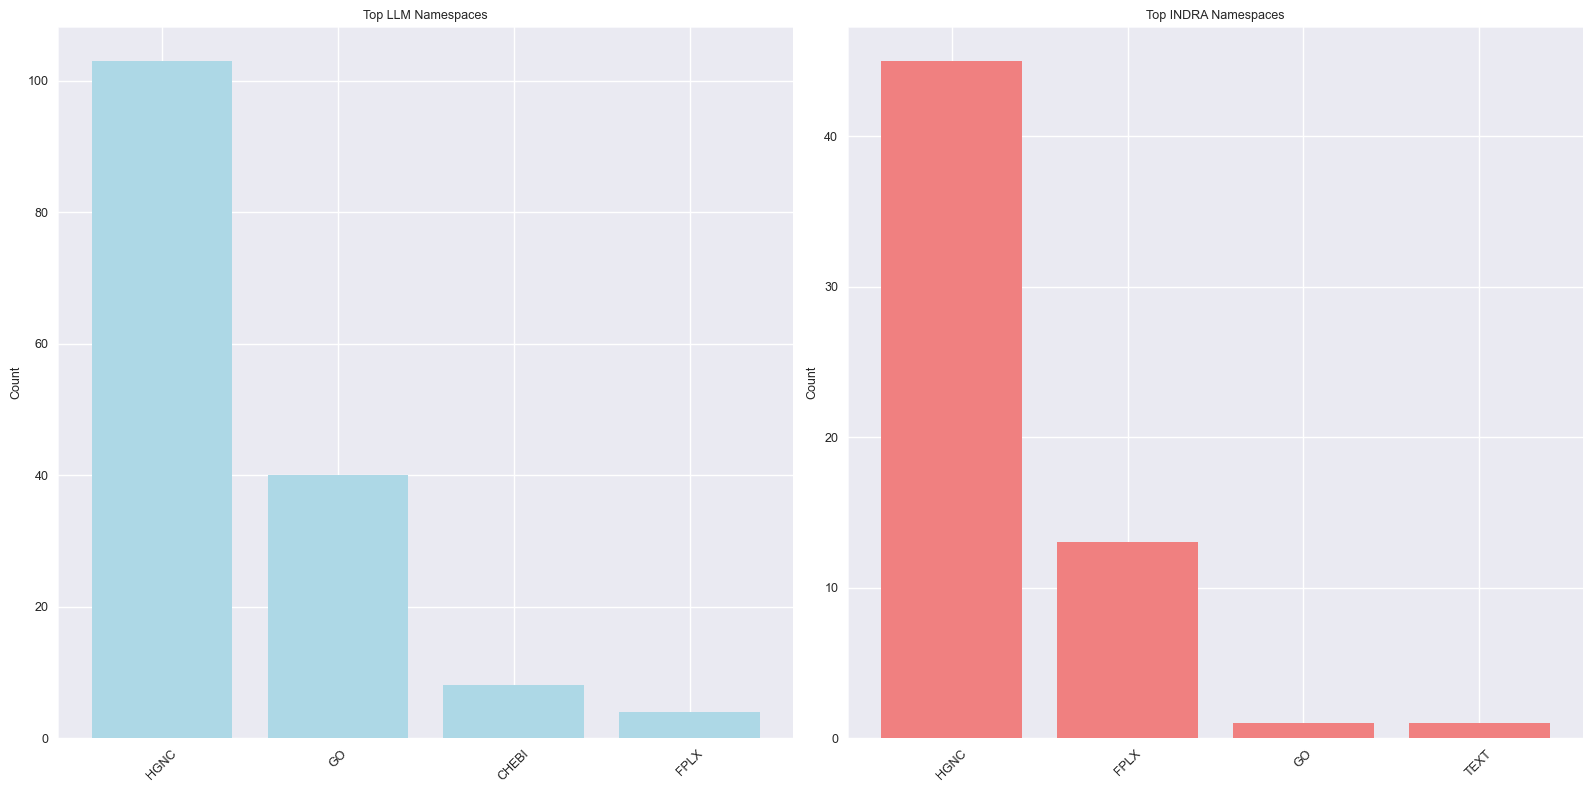

In [13]:
print("="*50)
print("NAMESPACE ANALYSIS")
print("="*50)

# Extract namespaces from subjects and objects
def extract_namespaces(text):
    """Extract namespaces from BEL components"""
    if pd.isna(text) or text is None:
        return []
    import re
    # Find patterns like HGNC:, GO:, CHEBI:, etc.
    namespaces = re.findall(r'\b([A-Z][A-Z0-9]*):(?:[^,\s\)]+|\"[^\"]+\")', str(text))
    return namespaces

# Collect all namespaces
llm_namespaces = []
indra_namespaces = []

for _, row in df.iterrows():
    # LLM namespaces
    llm_subj_ns = extract_namespaces(row['llm_subject'])
    llm_obj_ns = extract_namespaces(row['llm_object'])
    llm_namespaces.extend(llm_subj_ns + llm_obj_ns)
    
    # INDRA namespaces
    indra_subj_ns = extract_namespaces(row['indra_subject'])
    indra_obj_ns = extract_namespaces(row['indra_object'])
    indra_namespaces.extend(indra_subj_ns + indra_obj_ns)

llm_ns_counts = Counter(llm_namespaces)
indra_ns_counts = Counter(indra_namespaces)

print("LLM Namespace Usage:")
for ns, count in llm_ns_counts.most_common(10):
    print(f"  {ns}: {count}")

print("\nINDRA Namespace Usage:")
for ns, count in indra_ns_counts.most_common(10):
    print(f"  {ns}: {count}")

# Visualize namespace usage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# LLM namespaces
if llm_ns_counts:
    top_llm_ns = dict(llm_ns_counts.most_common(8))
    ax1.bar(top_llm_ns.keys(), top_llm_ns.values(), color='lightblue')
    ax1.set_title('Top LLM Namespaces')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

# INDRA namespaces
if indra_ns_counts:
    top_indra_ns = dict(indra_ns_counts.most_common(8))
    ax2.bar(top_indra_ns.keys(), top_indra_ns.values(), color='lightcoral')
    ax2.set_title('Top INDRA Namespaces')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

apply_luna_theme()
plt.tight_layout()
plt.show()

## Performance by Index/Evidence

In [8]:
print("="*50)
print("PERFORMANCE BY INDEX/EVIDENCE")
print("="*50)

# Performance by index
index_performance = df.groupby('index').agg({
    'match_type': lambda x: (x == 'Best Match').sum(),
    'similarity_rating': lambda x: (x == 'Good').sum(),
    'match_score': 'mean'
}).round(3)

index_performance.columns = ['Best_Matches', 'Good_Ratings', 'Avg_Match_Score']
index_performance = index_performance.sort_values('Best_Matches', ascending=False)

print("Performance by Index (Top 10):")
print(index_performance.head(10))

PERFORMANCE BY INDEX/EVIDENCE
Performance by Index (Top 10):
       Best_Matches  Good_Ratings  Avg_Match_Score
index                                             
3                 4             4            0.343
4                 2             2            0.308
6                 2             0            0.156
19                2             0            0.157
11                2             0            0.124
15                2             1            0.523
5                 1             0            0.088
13                1             1            0.250
14                1             0            0.432
1                 0             0            0.000


## Coverage Analysis

COVERAGE ANALYSIS
LLM-only statements: 45
INDRA-only statements: 12

Top relationship types in LLM-only statements:
llm_relationship
directlyIncreases    13
increases             6
decreases             5
hasComponent          1
directlyDecreases     1
Name: count, dtype: int64

Top relationship types in INDRA-only statements:
indra_relationship
increases            10
directlyIncreases     1
partOf                1
Name: count, dtype: int64


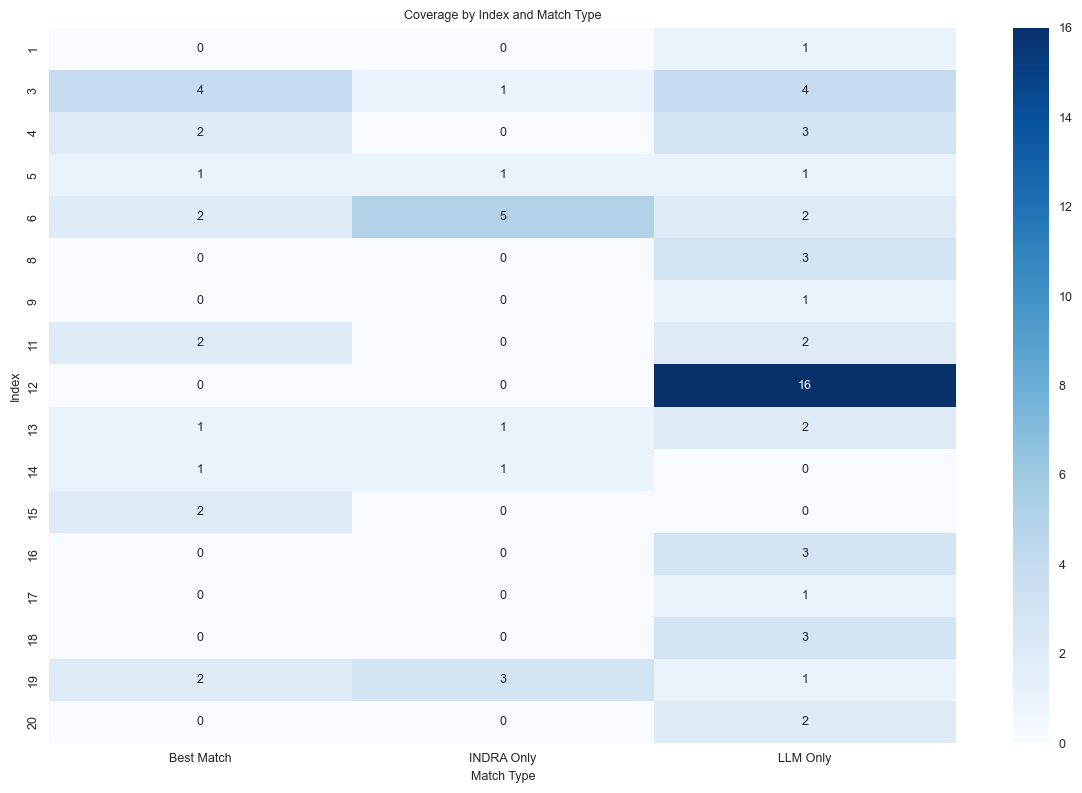

In [14]:
print("="*50)
print("COVERAGE ANALYSIS")
print("="*50)

# What does LLM find that INDRA doesn't?
llm_only = df[df['match_type'] == 'LLM Only']
print(f"LLM-only statements: {len(llm_only)}")

# What does INDRA find that LLM doesn't?
indra_only = df[df['match_type'] == 'INDRA Only']
print(f"INDRA-only statements: {len(indra_only)}")

# Relationship types in LLM-only vs INDRA-only
if len(llm_only) > 0:
    print(f"\nTop relationship types in LLM-only statements:")
    llm_only_rels = llm_only['llm_relationship'].value_counts().head(5)
    print(llm_only_rels)

if len(indra_only) > 0:
    print(f"\nTop relationship types in INDRA-only statements:")
    indra_only_rels = indra_only['indra_relationship'].value_counts().head(5)
    print(indra_only_rels)

# Create coverage heatmap by index
coverage_by_index = df.groupby('index')['match_type'].value_counts().unstack(fill_value=0)
if len(coverage_by_index) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(coverage_by_index, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Coverage by Index and Match Type')
    ax.set_ylabel('Index')
    ax.set_xlabel('Match Type')
    
    apply_luna_theme()
    plt.tight_layout()
    plt.show()

## Summary Statistics

In [10]:
print("="*50)
print("SUMMARY STATISTICS")
print("="*50)

summary = {
    'Total Comparisons': len(df),
    'Paired Statements': len(df[df['indra_statement'].notna()]),
    'LLM Only': len(df[df['match_type'] == 'LLM Only']),
    'INDRA Only': len(df[df['match_type'] == 'INDRA Only']),
    'Good Matches': len(df[df['similarity_rating'] == 'Good']),
    'Medium Matches': len(df[df['similarity_rating'] == 'Medium']),
    'Bad Matches': len(df[df['similarity_rating'] == 'Bad']),
    'High Score Matches (>0.8)': len(df[df['match_score'] > 0.8]),
    'Perfect Matches (Score = 1.0)': len(df[df['match_score'] == 1.0]),
}

print("Final Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

# Calculate success rate
paired_count = len(df[df['indra_statement'].notna()])
good_count = len(df[df['similarity_rating'] == 'Good'])
if paired_count > 0:
    success_rate = (good_count / paired_count) * 100
    print(f"\nOverall Success Rate: {success_rate:.1f}% (Good ratings / Paired statements)")

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)

SUMMARY STATISTICS
Final Summary:
Total Comparisons: 74
Paired Statements: 29
LLM Only: 45
INDRA Only: 12
Good Matches: 8
Medium Matches: 3
Bad Matches: 18
High Score Matches (>0.8): 3
Perfect Matches (Score = 1.0): 1

Overall Success Rate: 27.6% (Good ratings / Paired statements)

ANALYSIS COMPLETE!


In [11]:
print("Total rows in df:", len(df))
print("Paired rows:", len(df[df['indra_statement'].notna()]))
print("Unique INDRA BELs matched:", df['indra_statement'].nunique())
print("Unique LLM BELs matched:", df['llm_statement'].nunique())

Total rows in df: 74
Paired rows: 29
Unique INDRA BELs matched: 24
Unique LLM BELs matched: 56


In [12]:
print("Unique LLM BELs in matches:", df['llm_statement'].nunique())
print("Unique INDRA BELs in matches:", df['indra_statement'].nunique())

Unique LLM BELs in matches: 56
Unique INDRA BELs in matches: 24
